In [ ]:
#Setting all the input variables

storm_name = "dorian"
storm_year = 2019
storm_lowerLat= 40

latExtension = 2
lonExtension = 2
dateExtension = 2

focus_variable = "wind_spd_avg"
var_units = "(m s-1)"

#interest_variables = ["wind_spd", "wave_ht", "pressure"]
# Categories: Wind, Surface Waves, Pressure

In [119]:
# Getting storm data and matching ERDDAP datasets around the storm (time and space)

import tropycal.tracks as tracks
import pandas as pd
from erddapy import ERDDAP
from datetime import timedelta

basin = tracks.TrackDataset(basin='north_atlantic', source='ibtracs')
storm = basin.get_storm((storm_name,storm_year))

# Coordinate selector throws an error when using with Fiona but still generates the graph
storm = storm.sel(lat=[storm_lowerLat,None])

storm_dict = storm.interp().to_dict()
new_dict = {
    'date':storm_dict['date'],
    'type':storm_dict['type'],
    'lat':storm_dict['lat'],
    'lon':storm_dict['lon'],
}

#storm_df = storm.to_dataframe()
storm_df = pd.DataFrame.from_dict(new_dict)

storm_df['lon'] = storm_df['lon'].apply(lambda x: x-360.0)
print(storm_df)

min_lat = storm_df['lat'].min()
min_lon = storm_df['lon'].min()
max_lat = storm_df['lat'].max()
max_lon =  storm_df['lon'].max()
start_date = storm_df.min()['date']
end_date = storm_df.max()['date']

print(max_lat)
print(max_lon)
print(end_date)

# Get datasets matching time and location criteria, plus a buffer zone

e = ERDDAP(
    server="https://cioosatlantic.ca/erddap", 
    protocol="tabledap",
    response="csv"
)

e.dataset_id = "allDatasets"

e.variables = [
    "datasetID",
    "minLongitude",
    "maxLongitude",
    "minLatitude",
    "maxLatitude",
    "minTime",
    "maxTime"
]

e.constraints = {
    "minTime<=": end_date + timedelta(days = dateExtension),
    "maxTime>=": start_date- timedelta(days = dateExtension),
    "minLatitude>=": min_lat - latExtension,
    "maxLatitude<=": max_lat + latExtension,
    "minLongitude>=": min_lon - lonExtension,
    "maxLongitude<=": max_lon + lonExtension,
}

datasets_df = e.to_pandas(
    parse_dates=True,
).dropna()
datasets = set(datasets_df["datasetID"])

--> Starting to read in ibtracs data
--> Completed reading in ibtracs data (9.1 seconds)
Using no lon bounds
                  date type    lat    lon
0  2019-09-07 12:00:00   HU  40.80 -66.90
1  2019-09-07 13:00:00   HU  41.13 -66.52
2  2019-09-07 14:00:00   HU  41.47 -66.13
3  2019-09-07 15:00:00   EX  41.80 -65.75
4  2019-09-07 16:00:00   LO  42.13 -65.37
5  2019-09-07 17:00:00   LO  42.47 -64.98
6  2019-09-07 18:00:00   LO  42.80 -64.60
7  2019-09-07 19:00:00   LO  43.20 -64.32
8  2019-09-07 20:00:00   LO  43.60 -64.03
9  2019-09-07 21:00:00   LO  44.00 -63.75
10 2019-09-07 22:00:00   LO  44.40 -63.47
11 2019-09-07 23:00:00   LO  44.80 -63.18
12 2019-09-08 00:00:00   LO  45.20 -62.90
13 2019-09-08 01:00:00   LO  45.60 -62.73
14 2019-09-08 02:00:00   LO  46.00 -62.57
15 2019-09-08 03:00:00   EX  46.40 -62.40
16 2019-09-08 04:00:00   EX  46.80 -62.23
17 2019-09-08 05:00:00   EX  47.20 -62.07
18 2019-09-08 06:00:00   EX  47.60 -61.90
19 2019-09-08 07:00:00   EX  47.90 -61.65
20 2019-0

In [93]:
# Narrow down datasets that contain the focused variable
# Some datasets may not match at certain points if their coverage is inconsistent

matching_datasets = []
for dataset in datasets:
    info_url = e.get_info_url(dataset_id = dataset, response = "csv")
    dataset_info = pd.read_csv(info_url)

    variable_names = set(dataset_info["Variable Name"].unique())
    if focus_variable in variable_names:
         matching_datasets.append(dataset)

print(matching_datasets)

['SMA_halifax_anemometer1', 'DFO_Sutron_KLUMI', 'sma_negl_cartwright_junction_nlqu0004', 'SMA_saint_john', 'SMA_port_aux_basques', 'cna_werc_weather_10-min_avg', 'SMA_Holyrood_Buoy2', 'SMA_Fortune_Bay_Buoy', 'SMA_port_aux_basqes_wharf', 'SMA_red_island_shoal', 'SMA_saint_john_cruise_terminal', 'SMA_halifax_pier9c', 'SMA_holyrood_wharf', 'sma_negl_north_west_river_nlqu0007', 'SMA_saint_john_wharf', 'sma_negl_red_bay_nlqu0005', 'SMA_halifax', 'sma_negl_black_tickle_nlqu0003', 'SMA_MouthofPlacentiaBayBuoy', 'SMA_halifax_fairview']


In [127]:
# Find most recent values for focus var given a time point

selected_time=  start_date + timedelta(hours = 16)
matching_points = pd.DataFrame()

e = ERDDAP(
    server="https://cioosatlantic.ca/erddap", 
    protocol="tabledap",
    response="csv",
)

for dataset in matching_datasets:

    e.dataset_id = dataset
    print(dataset)
    
    e.constraints = {
        "time<=": selected_time,
        "time>=": selected_time - timedelta(hours = 6)
    }
        
    e.variables = ["time", "longitude", "latitude", focus_variable]

    try:
        buoy_data= e.to_pandas(
            parse_dates=True,
        ).dropna()
        recent_row = buoy_data.tail(1)
        print(recent_row["time (UTC)"].iloc[0])
        print(recent_row[focus_variable + " " + var_units].iloc[0])
        recent_row.insert(0, "dataset", dataset)
        matching_points = pd.concat([matching_points, recent_row.loc[:]]).reset_index(drop=True)
    except:
        print("couldn't find info for the given dataset for the given time")
    print("-")
matching_points.set_index('dataset')


SMA_halifax_anemometer1
couldn't find info for the given dataset for the given time
-
DFO_Sutron_KLUMI
couldn't find info for the given dataset for the given time
-
sma_negl_cartwright_junction_nlqu0004
2019-09-08T03:52:00Z
3.8888888
-
SMA_saint_john
2019-09-08T03:53:01Z
11.3
-
SMA_port_aux_basques
2019-09-08T03:54:01Z
17.9
-
cna_werc_weather_10-min_avg
2019-09-08T04:00:00Z
couldn't find info for the given dataset for the given time
-
SMA_Holyrood_Buoy2
2019-09-08T03:53:00Z
4.2
-
SMA_Fortune_Bay_Buoy
2019-09-08T03:53:41Z
15.9
-
SMA_port_aux_basqes_wharf
2019-09-08T03:59:52Z
5.5
-
SMA_red_island_shoal
2019-09-08T03:55:00Z
13.2
-
SMA_saint_john_cruise_terminal
2019-09-08T04:00:00Z
12.3
-
SMA_halifax_pier9c
couldn't find info for the given dataset for the given time
-
SMA_holyrood_wharf
2019-09-08T03:46:08Z
6.4
-
sma_negl_north_west_river_nlqu0007
2019-09-08T03:16:00Z
1.9722222
-
SMA_saint_john_wharf
2019-09-08T03:59:36Z
11.0
-
sma_negl_red_bay_nlqu0005
2019-09-08T03:52:00Z
8.083333
-
SMA

,time (UTC),longitude (degrees_east),latitude (degrees_north),wind_spd_avg (m s-1)
dataset,,,,
sma_negl_cartwright_junction_nlqu0004,2019-09-08T03:52:00Z,-58.453140,52.719830,3.888889
SMA_saint_john,2019-09-08T03:53:01Z,-66.113767,45.197167,11.300000
SMA_port_aux_basques,2019-09-08T03:54:01Z,-59.100398,47.562842,17.900000
SMA_Holyrood_Buoy2,2019-09-08T03:53:00Z,-53.108107,47.461835,4.200000
SMA_Fortune_Bay_Buoy,2019-09-08T03:53:41Z,-55.498453,47.260857,15.900000
SMA_port_aux_basqes_wharf,2019-09-08T03:59:52Z,-59.139467,47.574533,5.500000
SMA_red_island_shoal,2019-09-08T03:55:00Z,-54.122208,47.318377,13.200000
SMA_saint_john_cruise_terminal,2019-09-08T04:00:00Z,-66.061167,45.266833,12.300000
SMA_holyrood_wharf,2019-09-08T03:46:08Z,-53.134950,47.388657,6.400000


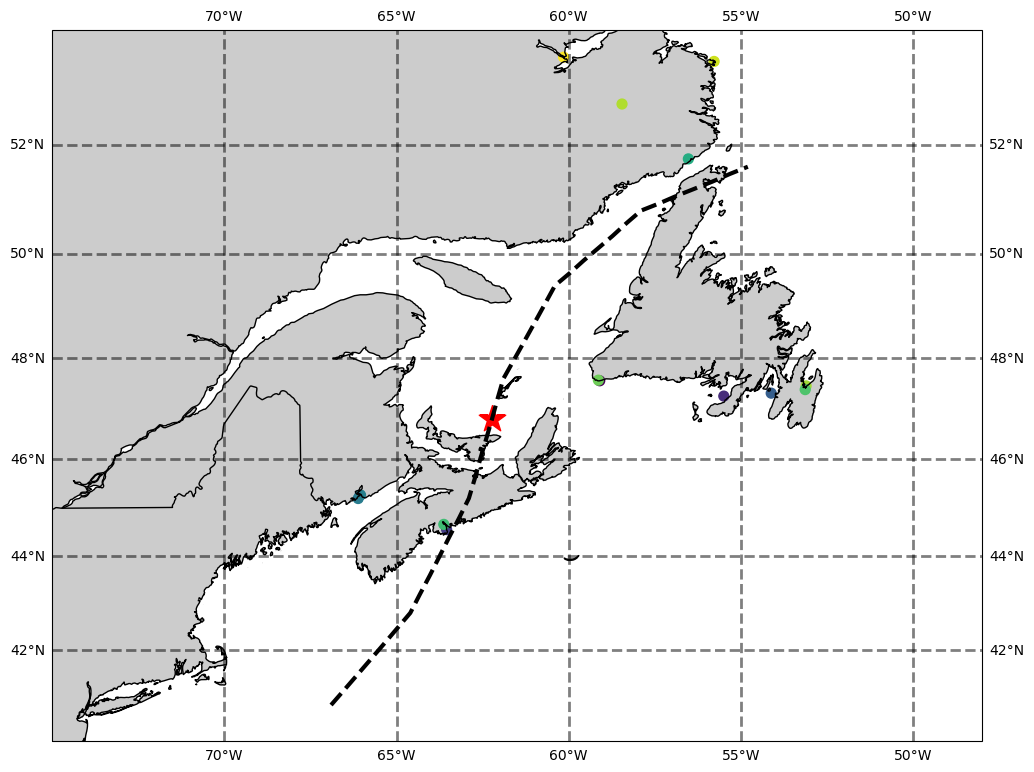

In [128]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
try:
    import cartopy.feature as cfeature
    from cartopy import crs as ccrs
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
except:
    warnings.warn("Warning: Cartopy is not installed in your python environment. Plotting functions will not work.")

                                
proj = ccrs.Mercator(central_longitude=305, min_latitude=40, max_latitude=54)
fig, ax = plt.subplots(subplot_kw=dict(projection=proj), figsize=(12,12))
ax.set_extent([312 , 285, 40, 54], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, facecolor='0.8')
ax.add_feature(cfeature.BORDERS, zorder=10)
ax.add_feature(cfeature.COASTLINE, zorder=10)
gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=2, color='black', alpha=0.5, linestyle='--', draw_labels=True)

gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

ax.scatter(x=matching_points['longitude (degrees_east)'], y=matching_points['latitude (degrees_north)'],  
           c=matching_points['wind_spd_avg (m s-1)'], cmap = 'viridis_r', marker = '.', s=200, transform=ccrs.PlateCarree())

# Convert storm to dataframe / dictionary

ax.plot(storm_df['lon'],storm_df['lat'], linestyle = 'dashed', linewidth =3, c= 'black', transform=ccrs.PlateCarree())


mask = (storm_df['date'] <= selected_time) & (storm_df['date'] > (selected_time - timedelta(hours=  6)))
storm_position = storm_df.loc[mask].tail(1)
ax.scatter(x=storm_position['lon'].iloc[0], y=storm_position['lat'].iloc[0], c= 'red', 
           marker = '*', s=400, transform=ccrs.PlateCarree())


In [ ]:
# Create plots  for matching datasets
e = ERDDAP(
    server="https://cioosatlantic.ca/erddap", 
    protocol="tabledap",
    response="csv",
)

for dataset in matching_datasets:

    # Still keeps generating graph after dataset fails for some reason?

    e.dataset_id = dataset

    e.constraints = {
        "time>=": start_date - timedelta(days = 2),
        "time<=": end_date + timedelta(days = 2)
    }

    e.variables = ["time", "longitude", "latitude", focus_variable]

    try:
        buoy_data= e.to_pandas(
            parse_dates=True,
        ).dropna()
        buoy_data.plot(x='time (UTC)', y=focus_variable + ' ' + var_units, title=dataset)
    except:
        print("Data does not exist for %s", dataset) 
